In [111]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
l = 1000 # 1000 time steps
t = np.linspace(0, 100, l) # a time interval of 100 seconds
a = np.zeros(1000) # initialize accelaration
v = np.zeros(1000) # initialize velocity
s = np.zeros(1000) # initialize position
variance_Zs = 0 # variance of system error with respect to position
variance_Zv = 0  # variance of system error with respect to velocity
variance_Za = 0 # variance of system error with respect to acceleration
variance_Ms = 0.1 # /sigma_Ms^2 = 20 # variance of measurement error with respect to position
variance_Mv = 0.01 # /sigma_Ms^2 = 2 # variance of measurement error with respect to velocity
variance_Ma = 0.0001 # /sigma_Ma^2 =0.2 # variance of measurement error with respect to acceleration
noise_Zs = np.random.normal(0,variance_Zs,1000)
noise_Zv = np.random.normal(0,variance_Zv,1000) 
noise_Za = np.random.normal(0,variance_Za,1000) 
noise_Ms = np.random.normal(0,variance_Ms,1000)  
noise_Mv = np.random.normal(0,variance_Mv,1000)
noise_Ma = np.random.normal(0,variance_Ma,1000)
Ts = 100/l
Ad = np.matrix([[1,Ts,0.5*(Ts*Ts)],
                  [0,1,Ts],
                  [0,0,0]]) ## not sure if it should be 0,0,1 (from textbook) or 0,0,0 (from my derivation)
Bd = np.array ([0.5*(Ts*Ts),Ts,1]).reshape(-1,1)
u = np.zeros((1,1000))
u[:,200:225] = -10 # step function
G = np.matrix ([[1,0,0],[0,1,0],[0,0,1]])
Gd = Ad
Md = Gd
z = np.vstack((noise_Zs,noise_Zv,noise_Za))
w = np.vstack((noise_Ms,noise_Mv,noise_Ma))
StateMatrix = np.zeros((3,1000))
MeasurementMatrix = np.zeros((3,1000))
v[0] = 50
x = np.array ([[s[0]],[v[0]],[a[0]]])
y = np.array ([0,0,1])
z_0 = z[:,0].reshape (3,1)
w_0 = w[:,0].reshape (3,1)
C = np.matrix ([[1,0,0],[0,1,0],[0,0,1]])
D = np.array ([0,0,1]).reshape(-1,1)
StateMatrix[:,0] = np.squeeze(x)
MeasurementMatrix[:,0] = np.squeeze(y)
for k in range(0, len(t)):
      z_k = z[:,k].reshape (3,1)
      w_k = w[:,k].reshape (3,1)
      u_k = u[:,k].reshape (1,1)
      x = Ad * x + Bd * u_k + Gd * z_k
      y = C * x + Md * w_k
      StateMatrix[:,k] = np.squeeze(x)
      MeasurementMatrix[:,k] = np.squeeze(y)

In [112]:
Q = np.diag([variance_Zs, variance_Zv, variance_Za]) 

R = np.diag([variance_Ms, variance_Mv, variance_Ma])

In [113]:
# Kalman filter implementation
StateEstimate = np.zeros((3, len(t)))
# Initial state estimate
#x_hat = np.zeros((3, 1))
#here I give a more precise inital estimated value, hoping to imprive the performance
x_hat = np.array([0, 50, 0]).reshape(-1, 1)

StateEstimate[:,0] = np.squeeze(x_hat)

Ad_f = np.matrix([[1,Ts,0.5*(Ts*Ts)],
                    [0,1,Ts],
                   [0,0,0]]) ## not sure if it should be 0,0,1 (from textbook) or 0,0,0 (from my derivation)

# Ad_f = np.matrix([[1,Ts,0.5*(Ts*Ts)],
#                     [0,1,Ts],
#                    [0,0,1]]) ## not sure if it should be 0,0,1 (from textbook) or 0,0,0 (from my derivation)


# Initial error covariance matrix
P = np.diag([1000, 1000, 1000])

for k in range(0, len(t)):

    # Prediction step

    #x_hat_minus = Ad.dot(x_hat) + Bd.dot(u[:,k].reshape(-1,1))
    #x_hat_minus is the predicted state of the 
    
    #should we include the term Bd*u in  the prediction step of Kalman Filter? 
    #I would say we shouldn't, because we do not know about the control input of the other vehicles.
    x_hat_minus = Ad_f.dot(x_hat)
    
    P_minus = Ad_f.dot(P).dot(Ad.T) + Gd.dot(Q).dot(Gd.T)

    # Update step

    y = MeasurementMatrix[:,k].reshape(-1,1)
    S = C.dot(P_minus).dot(C.T) + Md.dot(R).dot(Md.T)
    #K = P_minus.dot(C.T).dot(np.linalg.inv(S))
    K = P_minus.dot(C.T).dot(np.linalg.pinv(S))
    x_hat = x_hat_minus + K.dot(y - C.dot(x_hat_minus))
    P = (np.eye(3) - K.dot(C)).dot(P_minus)
    
    # Save the estimated state
    StateEstimate[:,k] = np.squeeze(x_hat)

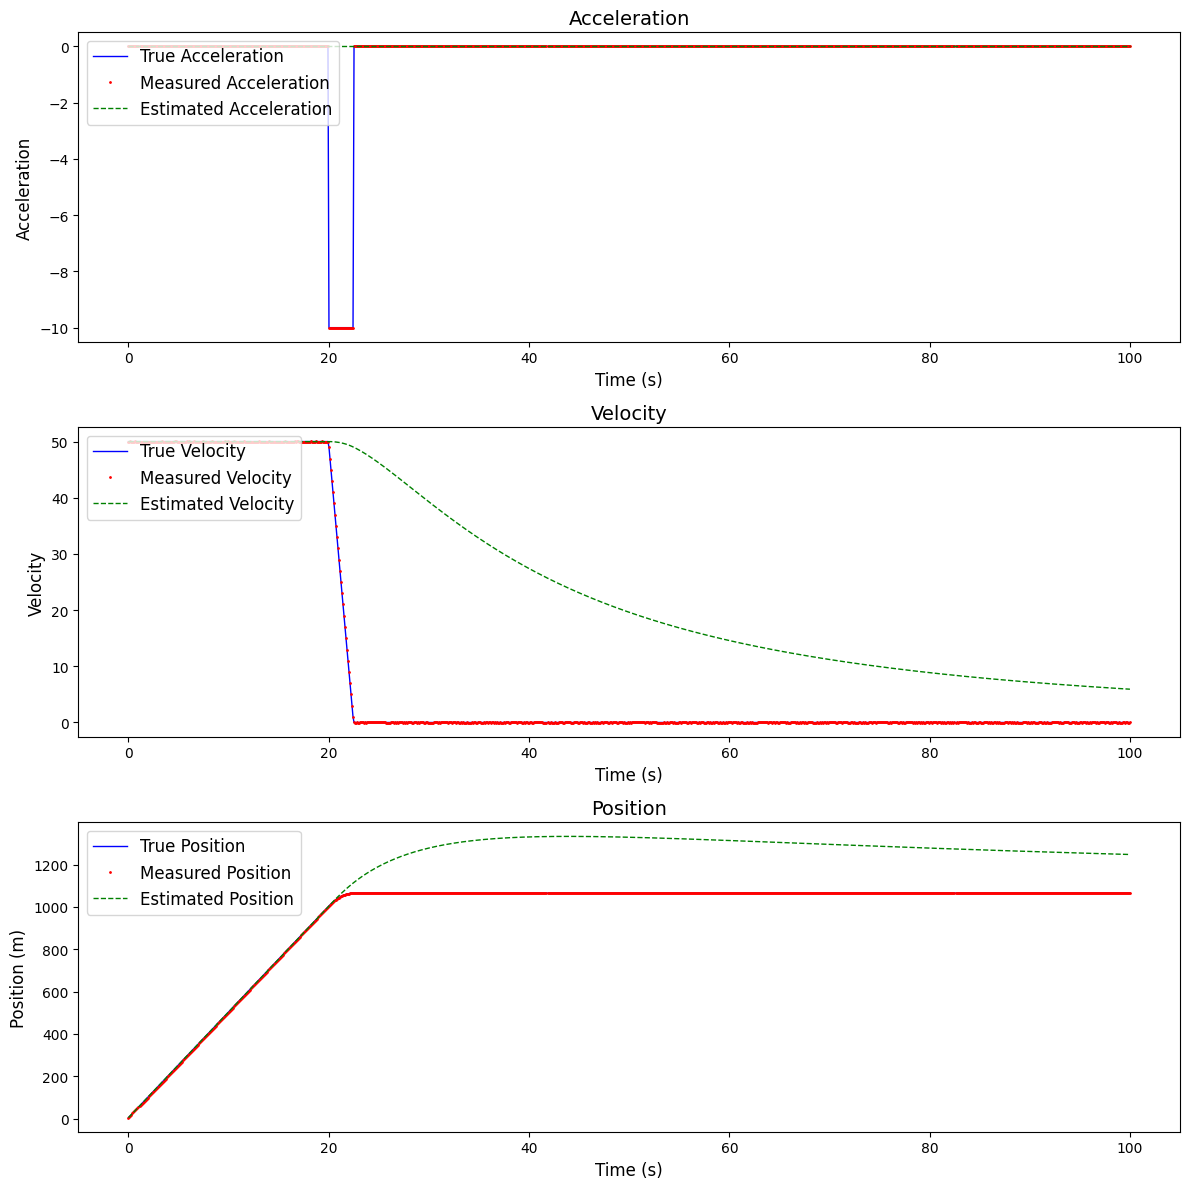

In [114]:
import matplotlib.pyplot as plt

# Plotting the true, measured, and estimated position
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

axs[0].plot(t, StateMatrix[2, :], linewidth=1, color='blue', label='True Acceleration')
axs[0].plot(t, MeasurementMatrix[2, :], 'o', markersize=1, color='red', label='Measured Acceleration')
axs[0].plot(t, StateEstimate[2, :], '--', linewidth=1, color='green', label='Estimated Acceleration')
axs[0].legend(loc='upper left', fontsize=12)
axs[0].set_xlabel('Time (s)', fontsize=12)
axs[0].set_ylabel('Acceleration', fontsize=12)
axs[0].set_title('Acceleration', fontsize=14)

axs[1].plot(t, StateMatrix[1, :], linewidth=1, color='blue', label='True Velocity')
axs[1].plot(t, MeasurementMatrix[1, :], 'o', markersize=1, color='red', label='Measured Velocity')
axs[1].plot(t, StateEstimate[1, :], '--', linewidth=1, color='green', label='Estimated Velocity')
axs[1].legend(loc='upper left', fontsize=12)
axs[1].set_xlabel('Time (s)', fontsize=12)
axs[1].set_ylabel('Velocity', fontsize=12)
axs[1].set_title('Velocity', fontsize=14)


axs[2].plot(t, StateMatrix[0, :], linewidth=1, color='blue', label='True Position')
axs[2].plot(t, MeasurementMatrix[0, :], 'o', markersize=1, color='red', label='Measured Position')
axs[2].plot(t, StateEstimate[0, :], '--', linewidth=1, color='green', label='Estimated Position')
axs[2].legend(loc='upper left', fontsize=12)
axs[2].set_xlabel('Time (s)', fontsize=12)
axs[2].set_ylabel('Position (m)', fontsize=12)
axs[2].set_title('Position', fontsize=14)

plt.tight_layout()
plt.show()